In [1]:
import glob
import numpy as np
from scipy.interpolate import griddata, UnivariateSpline


import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Polygon, ConnectionPatch
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable


from blg_strain.utils.saver import load, Saver
from blg_strain.lattice import StrainedLattice, brillouin_zone
from blg_strain.bands import BandStructure, FilledBands, get_bands
from blg_strain.macroscopic import integrand_by_parts
from blg_strain.utils.const import q, hbar, muB, a0, hbar_J, mu0
from blg_strain.strayfield import *

gr = (5**.5 + 1) / 2
width_in = 3.375  # column width in inches

In C:\Users\Brian\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Brian\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Brian\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\Brian\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Brian\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

In [2]:
# mpl.font_manager._rebuild()

In [3]:
# %matplotlib notebook

In [4]:
mpl.rc_file('sBLG.rc')

In [5]:
pcolormesh_params = dict(rasterized=True, shading='gouraud')

In [6]:
def savefig(fig, filename, columns=1, dpi=400, tweak_height=1, shift_x=0, shift_y=0):
    assert columns in [1, 1.5, 2]
    width = 3.375 * columns  # width in inches
    
    # get the center of the plot area
    x0, y0, w, h = [fig.bbox.bounds[i]/100 for i in range(4)]
    xcenter = x0 + w/2
    ycenter = y0 + h/2
    
    # bbox that is the width of the specified number of columns and with an automatic height
    bbox = mpl.transforms.Bbox.from_bounds(xcenter - width/2 + shift_x, y0 - h*(tweak_height-1)/2 + shift_y, width, h * tweak_height)
    
    fig.savefig(filename, bbox_inches=bbox, transparent=True, dpi=dpi)

In [7]:
cmapM = 'coolwarm'
cmapA = 'PuOr'
cmapB = 'RdBu'

In [229]:
import colorcet

In [235]:
cmapA = colorcet.cm.bjy

# Test fonts and colormap

<IPython.core.display.Javascript object>


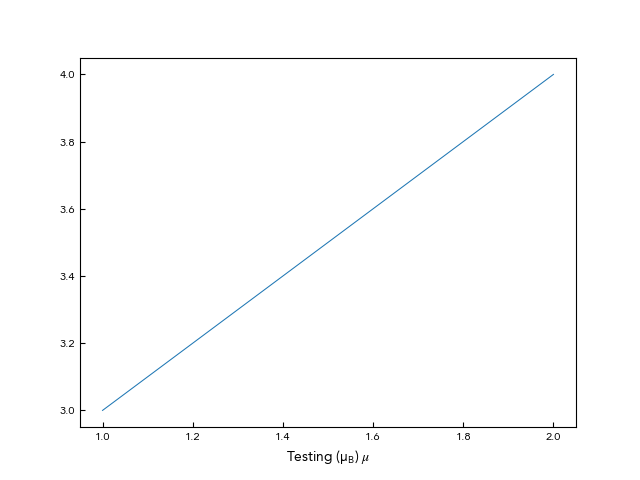

Text(0.5, 0, 'Testing ($\\mathregular{\\mu_B}$) $\\mu$')

In [236]:
fig, ax = plt.subplots()
ax.plot([1,2],[3,4])
ax.set_xlabel('Testing ($\mathregular{\mu_B}$) $\mu$')

<IPython.core.display.Javascript object>


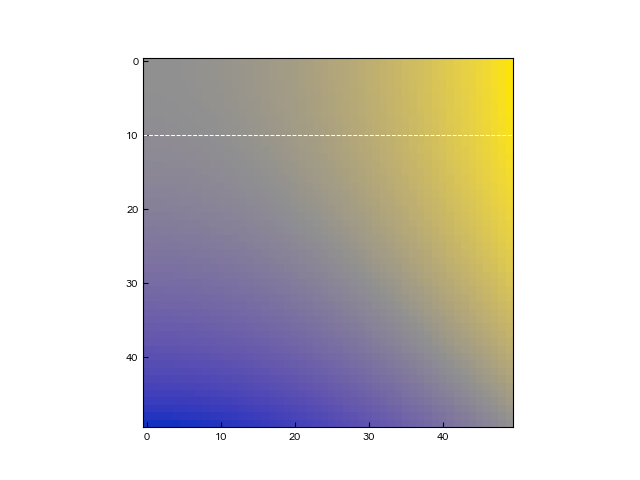

In [237]:
fig, ax = plt.subplots()
x = np.linspace(0,1)
X, Y = np.meshgrid(x, x)
ax.imshow(X**2-Y**2, cmap=cmapA)
ax.axhline(10, color='w', ls='--')

# FigureKspace - Brillouin Zone and magnetic moment

In [54]:
eps = 0.01
theta = 0
Delta = 0.007  # eV
EF = 0.010  # eV


In [55]:
sl = StrainedLattice(eps, theta)
sl.calculate()
bs = BandStructure(sl, Delta=Delta)
bs.calculate(600, 600)
fb = FilledBands(bs, EF=EF)
fb.calculate(600, 600)

sl0 = StrainedLattice(0, 0)
sl0.calculate()
bs0 = BandStructure(sl0, Delta=Delta)
bs0.calculate(600, 600)
fb0 = FilledBands(bs0, EF=EF)
fb0.calculate(600, 600)

KeyboardInterrupt: 

In [ ]:
# Energy for full BZ
K = 4 * np.pi / (3 * np.sqrt(3))
kxa = np.linspace(-1.2 * K, 1.2 * K, 500)
kya = kxa
Kxa, Kya = np.meshgrid(kxa, kya)

E, Psi = get_bands(Kxa, Kya, sl, Delta=Delta)

In [ ]:
bz0 = brillouin_zone(sl0.strain)
bz = brillouin_zone(sl.strain)

M = bs.Mu[2] + q * bs.Omega[2] / hbar * (EF - bs.E[2])
M = M / muB  # A * m^2 -> Bohr magnetons
M1 = bs.Mu[1] + q * bs.Omega[1] / hbar * (EF - bs.E[1])
M1 = M1 / muB  # A * m^2 -> Bohr magnetons
dM = integrand_by_parts(bs.kxa, bs.kya, bs.splE[2], bs.splO[2], bs.splM[2], EF=EF)
dMy = integrand_by_parts(bs.kxa, bs.kya, bs.splE[2], bs.splO[2], bs.splM[2], EF=EF, dx=False)
prefactor = - a0 * q * mu0 / (hbar_J) / (2 * np.pi * a0) ** 2
dM = dM / prefactor / muB / np.sqrt(3) # A * m^2 / a0 -> Bohr magnetons / a
dMy = dMy / prefactor / muB / np.sqrt(3) # A * m^2 / a0 -> Bohr magnetons / a

# Zero strain
M0 = bs0.Mu[2] + q * bs0.Omega[2] / hbar * (EF - bs0.E[2])
M0 = M0 / muB  # A * m^2 -> Bohr magnetons
M01 = bs0.Mu[1] + q * bs0.Omega[1] / hbar * (EF - bs0.E[1])
M01 = M01 / muB  # A * m^2 -> Bohr magnetons

dM0 = integrand_by_parts(bs0.kxa, bs0.kya, bs0.splE[2], bs0.splO[2], bs0.splM[2], EF=EF)
prefactor = - a0 * q * mu0 / (hbar_J) / (2 * np.pi * a0) ** 2
dM0 = dM0 / prefactor / muB / np.sqrt(3) # A * m^2 / a0 -> Bohr magnetons / a

In [ ]:
fig = plt.figure(figsize=(2.3*width_in, 3))
# Fake axes to define area spanned by all subplots
ax = fig.add_subplot(111, frameon=False)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.grid(False)

gs = fig.add_gridspec(2, 7, width_ratios=[1.5, .2, 1.5, .2, 1.5, .2, 1.5])
axKE = fig.add_subplot(gs[0, 0])
axKpE = fig.add_subplot(gs[1, 0])
axKM = fig.add_subplot(gs[0, 2])
axKpM = fig.add_subplot(gs[1, 2])
axKdM = fig.add_subplot(gs[0, 4])
axKpdM = fig.add_subplot(gs[1, 4])
axKdMy = fig.add_subplot(gs[0, 6])
axKpdMy = fig.add_subplot(gs[1, 6])



# K and K' - E
imKE = axKE.pcolormesh(bs.Kxa, bs.Kya, bs.E[2]*1e3,  **pcolormesh_params, cmap='cividis', vmin=0, vmax=70)
axKE.contour(bs.Kxa, bs.Kya,  bs.E[2]*1e3, colors='#444444', levels=20, linewidths=0.5, alpha=1, zorder=1)
imKpE = axKpE.pcolormesh(-bs.Kxa, -bs.Kya, bs.E[2]*1e3,  **pcolormesh_params, cmap='cividis', vmin=0, vmax=70)
axKpE.contour(-bs.Kxa, -bs.Kya,  bs.E[2]*1e3, colors='#444444', levels=20, linewidths=0.5, alpha=1, zorder=1)


# K and K' - M
norm_M=mpl.colors.SymLogNorm(linthresh=1, linscale=0, vmin=-1e3, vmax=1e3)
im02 = axKM.pcolormesh(bs.Kxa, bs.Kya, M, **pcolormesh_params, cmap=cmapM, norm=norm_M)
axKpM.pcolormesh(-bs.Kxa, -bs.Kya, -M, **pcolormesh_params, cmap=cmapM, norm=norm_M)

# K and K' - dM
norm_dM=mpl.colors.SymLogNorm(linthresh=1e2, linscale=0,  vmin=-1e5, vmax=1e5)
im04 = axKdM.pcolormesh(bs.Kxa, bs.Kya, dM, **pcolormesh_params, cmap=cmapM, norm=norm_dM)
axKpdM.pcolormesh(-bs.Kxa, -bs.Kya, dM, **pcolormesh_params, cmap=cmapM, norm=norm_dM)

im08 = axKdMy.pcolormesh(bs.Kxa, bs.Kya, dMy, **pcolormesh_params, cmap=cmapM, norm=norm_dM)
axKpdMy.pcolormesh(-bs.Kxa, -bs.Kya, dMy, **pcolormesh_params, cmap=cmapM, norm=norm_dM)
# dM picks up a negative sign in K' because the derivative does not undergo spatial inversion


# E=EF contours
axKE.plot(fb.contours[2][0][:,0], fb.contours[2][0][:,1], 'k')
axKpE.plot(-fb.contours[2][0][:,0], -fb.contours[2][0][:,1], 'k')
axKM.plot(fb.contours[2][0][:,0], fb.contours[2][0][:,1], 'k')
axKpM.plot(-fb.contours[2][0][:,0], -fb.contours[2][0][:,1], 'k')
axKdM.plot(fb.contours[2][0][:,0], fb.contours[2][0][:,1], 'k')
axKpdM.plot(-fb.contours[2][0][:,0], -fb.contours[2][0][:,1], 'k')
axKdMy.plot(fb.contours[2][0][:,0], fb.contours[2][0][:,1], 'k')
axKpdMy.plot(-fb.contours[2][0][:,0], -fb.contours[2][0][:,1], 'k')

# Zoom in by a factor of 2
for a in [axKE, axKpE, axKM, axKpM, axKdM, axKpdM, axKdMy, axKpdMy]:
    x0, x1 = a.get_xlim()
    y0, y1 = a.get_ylim()
    a.set_xlim((x0 + x1) / 2 - (x1 - x0) / 4, (x0 + x1) / 2 + (x1 - x0) / 4)
    a.set_ylim((y0 + y1) / 2 - (y1 - y0) / 4, (y0 + y1) / 2 + (y1 - y0) / 4)
    a.set_xticks([])
    a.set_yticks([])
    a.set_aspect('equal')
    
    
## colorbar E
l, b, w, h = axKE.get_position().bounds
cax = fig.add_axes([l, b + h + .03, w, .02])
cbar = plt.colorbar(imKE, cax=cax, orientation='horizontal')
cax.tick_params(direction='out', which='both')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')
cax.set_xlabel(r'$E_2$ (meV)', labelpad=8)
cbar.set_ticks([0, 30, 60])

    
## colorbar M
l, b, w, h = axKM.get_position().bounds
cax = fig.add_axes([l, b + h + .03, w, .02])
cbar = plt.colorbar(im02, cax=cax, orientation='horizontal')
cax.tick_params(direction='out', which='both')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')
cax.set_xlabel(r'$\mathcal{M}^z_2$ (${\mu_{\mathrm{B}}}$)', labelpad=8)
# cax.text(1.2, 0.5, r'$\mathcal{M}^z_2$ ($\mu_{\mathrm{B}}$)', transform=cax.transAxes, va='center')
cbar.set_ticks([-1e3, 0, 1e3])
labels = cax.get_xticklabels()
labels[1] = '$\\mathdefault{\pm1}$'
cax.set_xticklabels(labels)
values = np.arange(2,10)**3
minorticks = norm_M(1 * np.concatenate((-values[::-1], values))) # Log-spaced ticks from 1 to 10^3
cax.xaxis.set_ticks(minorticks, minor=True)
    
## colorbar dM
l, b, w, h = axKdM.get_position().bounds
cax = fig.add_axes([l, b + h + .03, w, .02])
cbar = plt.colorbar(im04, cax=cax, orientation='horizontal')
cax.tick_params(direction='out', which='both')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')
cax.set_xlabel(r'$\partial_{k_x}\mathcal{M}^z_2$ (${\mu_{\mathrm{B}}a}$)', labelpad=8)
# cax.text(1.2, 0.5, r'$\partial_{k_x}\mathcal{M}^z_2$ ($10^3$ $\mu_{\mathrm{B}}/a$)', transform=cax.transAxes, va='center')
cbar.set_ticks([-1e5, 0, 1e5])
labels = cax.get_xticklabels()
labels[1] = '$\\mathdefault{\pm10^2}$'
cax.set_xticklabels(labels)
values = np.arange(2,10)**3
minorticks = norm_dM(1e2 * np.concatenate((-values[::-1], values))) # Log-spaced ticks from 10^2 to 10^5
cax.xaxis.set_ticks(minorticks, minor=True);

## colorbar dMy
l, b, w, h = axKdMy.get_position().bounds
cax = fig.add_axes([l, b + h + .03, w, .02])
cbar = plt.colorbar(im08, cax=cax, orientation='horizontal')
cax.tick_params(direction='out', which='both')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')
cax.set_xlabel(r'$\partial_{k_y}\mathcal{M}^z_2$ (${\mu_{\mathrm{B}}a}$)', labelpad=8)
# cax.text(1.2, 0.5, r'$\partial_{k_x}\mathcal{M}^z_2$ ($10^3$ $\mu_{\mathrm{B}}/a$)', transform=cax.transAxes, va='center')
cbar.set_ticks([-1e5, 0, 1e5])
labels = cax.get_xticklabels()
labels[1] = '$\\mathdefault{\pm10^2}$'
cax.set_xticklabels(labels)
values = np.arange(2,10)**3
minorticks = norm_dM(1e2 * np.concatenate((-values[::-1], values))) # Log-spaced ticks from 10^2 to 10^5
cax.xaxis.set_ticks(minorticks, minor=True);

# # Draw BZ corner for zoomed in
# p = Polygon(bz, fill=False, color='w', lw=1, zorder=10) # zorder=10 to put on top
# axKE.add_patch(p)
# ## shift bz hexagon to show the "correct" corner
# p = Polygon(np.array(bz)+bz[4]+bz[3], fill=False, color='w', lw=1, zorder=10) # zorder=10 to put on top
# axKpE.add_patch(p)
# # put hexagon behind axis spines
# for k, spine in axKE.spines.items():  #ax.spines is a dictionary
#     spine.set_zorder(50)
# for k, spine in axKpE.spines.items():  #ax.spines is a dictionary
#     spine.set_zorder(50)




# K, K' labels
axKE.text(-.5, .5, 'K', color='k', size=16, va='center', transform=axKE.transAxes, fontweight='bold')
axKpE.text(-.5, .5, 'K’', color='k', size=16, va='center', transform=axKpE.transAxes, fontweight='bold')
# axKE.text(.05, .1, 'K', color='k', size=8, va='center', transform=axKE.transAxes, fontweight='bold')
# axKpE.text(.05, .1, 'K’', color='k', size=8, va='center', transform=axKpE.transAxes, fontweight='bold')
# axKM.text(.05, .1, 'K', color='k', size=8, va='center', transform=axKM.transAxes, fontweight='bold')
# axKpM.text(.05, .1, 'K’', color='k', size=8, va='center', transform=axKpM.transAxes, fontweight='bold')
# axKdM.text(.05, .1, 'K', color='k', size=8, va='center', transform=axKdM.transAxes, fontweight='bold')
# axKpdM.text(.05, .1, 'K’', color='k', size=8, va='center', transform=axKpdM.transAxes, fontweight='bold')
# axKdMy.text(.05, .1, 'K', color='k', size=8, va='center', transform=axKdMy.transAxes, fontweight='bold')
# axKpdMy.text(.05, .1, 'K’', color='k', size=8, va='center', transform=axKpdMy.transAxes, fontweight='bold')


# Panel labels
axKE.text(-0.25, 1, '(a)', color='k', size=8, va='top', transform=axKE.transAxes)
axKpE.text(-0.25, 1, '(b)', color='k', size=8, va='top', transform=axKpE.transAxes)
axKM.text(-0.25, 1, '(c)', color='k', size=8, va='top', transform=axKM.transAxes)
axKpM.text(-0.25, 1, '(d)', color='k', size=8, va='top', transform=axKpM.transAxes)
axKdM.text(-0.25, 1, '(e)', color='k', size=8, va='top', transform=axKdM.transAxes)
axKpdM.text(-0.25, 1, '(f$\,$)', color='k', size=8, va='top', transform=axKpdM.transAxes)  # thin space for readability!
axKdMy.text(-0.25, 1, '(g)', color='k', size=8, va='top', transform=axKdMy.transAxes)
axKpdMy.text(-0.25, 1, '(h)', color='k', size=8, va='top', transform=axKpdMy.transAxes)

In [ ]:
print(EF)

In [15]:
savefig(fig, 'FigureKspace.pdf', 2, shift_x=-.1, shift_y=.2, tweak_height=1.1)

In [16]:
bs.Kxa.ptp()

0.09999999999999964

# FigHopping - 3D band insets with mag moment color

In [ ]:
eps = 0.01
theta = 0
Delta = 0.007  # eV
EF = 0.007  # eV # doesn't matter here, just copy/pasted


In [ ]:
sl = StrainedLattice(eps, theta)
sl.calculate()
bs = BandStructure(sl, Delta=Delta, window=0.05)
bs.calculate(1200, 1200)

sl0 = StrainedLattice(0, 0)
sl0.calculate()
bs0 = BandStructure(sl0, Delta=Delta, window=0.05)
bs0.calculate(1200, 1200)

In [ ]:
M = bs.Mu[2] + q * bs.Omega[2] / hbar * (EF - bs.E[2])
M = M / muB  # A * m^2 -> Bohr magnetons
M1 = bs.Mu[1] + q * bs.Omega[1] / hbar * (EF - bs.E[1])
M1 = M1 / muB  # A * m^2 -> Bohr magnetons

# Zero strain
M0 = bs0.Mu[2] + q * bs0.Omega[2] / hbar * (EF - bs0.E[2])
M0 = M0 / muB  # A * m^2 -> Bohr magnetons
M01 = bs0.Mu[1] + q * bs0.Omega[1] / hbar * (EF - bs0.E[1])
M01 = M01 / muB  # A * m^2 -> Bohr magnetons

norm_M=mpl.colors.SymLogNorm(linthresh=1, linscale=0, vmin=-1e2, vmax=1e2)

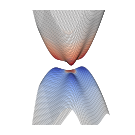

In [20]:
fig0 = plt.figure(figsize=(2,1.5))
ax0 = fig0.add_subplot(111, projection='3d')
ax0.axis('off')

fc1 = mpl.cm.coolwarm(norm_M(M01))
fc2 = mpl.cm.coolwarm(norm_M(M0))

surf01 = ax0.plot_surface(bs0.Kxa, bs0.Kya, bs0.E[1], facecolors=fc1, shade=False, lw=0.05, rasterized=True)#, alpha=0.5)
surf02 = ax0.plot_surface(bs0.Kxa, bs0.Kya, bs0.E[2], facecolors=fc2, shade=False, lw=0.05, rasterized=True)#, alpha=0.5)
surf01.set_edgecolor('k')
surf02.set_edgecolor('k')
# ax0.contour(bs0.Kxa, bs0.Kya, bs0.E[1]+.001, stride=1, colors='k')

ax0.set_zlim(-0.02, 0.02)
ax0.view_init(18.798701298701474, -66.5322580645161)

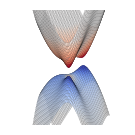

In [21]:
fig = plt.figure(figsize=(2,1.5))
ax = fig.add_subplot(111, projection='3d')
ax.axis('off')

# fc1 = mpl.cm.Blues(np.abs(M1/np.max(np.abs(M1))))
# fc2 = mpl.cm.Reds(M/np.max(np.abs(M)))

fc1 = mpl.cm.coolwarm(norm_M(M1))
fc2 = mpl.cm.coolwarm(norm_M(M))

surf01 = ax.plot_surface(bs.Kxa, bs.Kya, bs.E[1], facecolors=fc1, shade=False, lw=0.05, rasterized=True)#, alpha=0.5)
surf02 = ax.plot_surface(bs.Kxa, bs.Kya, bs.E[2], facecolors=fc2, shade=False, lw=0.05, rasterized=True)#, alpha=0.5)
surf01.set_edgecolor('k')
surf02.set_edgecolor('k')
# ax0.contour(bs0.Kxa, bs0.Kya, bs0.E[1]+.001, stride=1, colors='k')

ax.set_zlim(-0.02, 0.02)
ax.view_init(18.798701298701474, -66.5322580645161)

In [22]:
fig0.savefig('FigureHopping_bs_unstrained.pdf', transparent=True, dpi=1200)
fig.savefig('FigureHopping_bs_strained.pdf', transparent=True, dpi=1200)

# FigureSusc - susceptibility versus Delta, EF

In [23]:
width_in*2 / 3

2.25

In [24]:
width_in * 2.25

7.59375

<IPython.core.display.Javascript object>


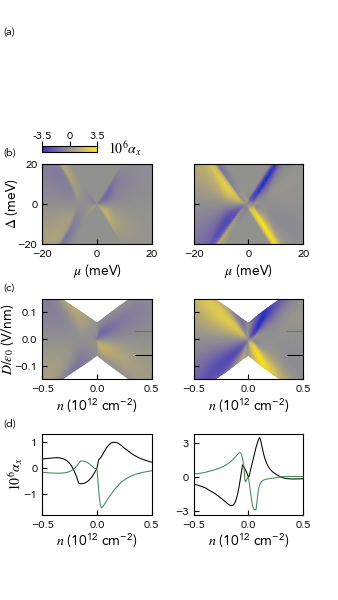

3.5584283949615696e-06


C:\Users\Brian\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\Brian\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator


1.5598681339552001e-06


Text(-0.35, 1.2, '(d)')

In [252]:
fig = plt.figure(figsize=(width_in, 6))

gs = fig.add_gridspec(7, 3, height_ratios=[1, 1, .4, 1, .4, 1, .1], width_ratios=[1, .1, 1])
ax_hidden = fig.add_subplot(gs[0,0])
ax_hidden.axis('off')
ax_zz = fig.add_subplot(gs[1, 0])
ax_ac = fig.add_subplot(gs[1, 2])
ax_zz2 = fig.add_subplot(gs[3, 0])
ax_ac2 = fig.add_subplot(gs[3, 2])
ax_zz3 = fig.add_subplot(gs[5, 0])
ax_ac3 = fig.add_subplot(gs[5, 2])

cmap = cmapA
v=3.5

# Zigzag and armchair
paths = ['data/summary_eps0.010_theta1.571.h5', 'data/summary_eps0.010_theta0.000.h5']
for i, (path, ax, ax2, ax3) in enumerate(zip(paths, [ax_ac, ax_zz], [ax_ac2, ax_zz2], [ax_ac3, ax_zz3])):
    s = Saver.load(path)
    Deltas, EFs, ns, Ds, alphas = s.Deltas, s.EFs, s.ns, s.Ds, s.alphas
    im = ax.pcolormesh(EFs, Deltas, alphas[:,:,0]*1e6, **pcolormesh_params, cmap=cmap, vmin=-v, vmax=v)
    print(alphas.max())
    ax.set_xlabel('$\mu$ (meV)', labelpad=2)
    if i == 1:
        ax.set_ylabel('$\Delta$ (meV)', labelpad=-2)
    else:
        ax.set_yticklabels([None, None, None ])
    # ax_zz.text(0.5, 0.9, r'$\theta=0$', transform=ax_zz.transAxes, ha='center')

    ## n/D map
    im2 = ax2.pcolormesh(ns * 1e-16, Ds * 1e-9, alphas[:,:,0]*1e6, **pcolormesh_params, cmap=cmap, vmin=-v, vmax=v)
    ax2.set_xlabel('$n$ $\mathdefault{(10^{12}\ cm^{-2})}$', labelpad=2)
    if i == 1:
        ax2.set_ylabel(r'$D/\varepsilon_0$ (V/nm)', labelpad=-1)
    else:
        ax2.set_yticklabels([None, None, None ])
    # ax_zz2.text(0.5, 0.9, r'$\theta=0$', transform=ax_zz2.transAxes, ha='center')
    ax2.set_xlim(-.5, .5)
    ax2.set_ylim(-.15, .15)

    ## linecuts (alpha vs. n at fixed D)
    points = np.vstack((ns.flatten() / 1e16, Ds.flatten() / 1e9)).T
    values = alphas[:,:,0].flatten() * 1e6
    Dlines = [-.06, .03]
    lss = ['-', '-']
#     c1 = '#8C8C8C'
    c1 = 'k'
    c2 = '#398D4F'
#     c2 = '#55A868'
    colors = [c1, c2, c2, c1]
    for D, ls, color in zip(Dlines, lss, colors):
        nn = np.linspace(-1, 1, 500)
        DD = np.ones_like(nn) * D
        xi = np.vstack((nn, DD)).T
        zi = griddata(points, values, xi, method='cubic')
        
        label = '{:.2f}'.format(D).replace('-', u'\u2212') # unicode hyphen
        ax3.plot(nn, zi, label=label, ls=ls, color=color)
        ax2.axhline(D, .85, 1, ls=ls, color=color)

#     if i == 0:
#         ax3.legend(bbox_to_anchor=(1.05, 1.05), loc='upper left', borderaxespad=0, title=r'$D/\varepsilon_0$ (V/nm)', handlelength=1, labelspacing=.1)
    ax3.set_xlabel('$n$ $\mathdefault{(10^{12}\ cm^{-2})}$', labelpad=2)
    if i == 1:
        ax3.set_ylabel(r'$10^6\alpha_x$', labelpad=-1)
    ax3.set_xlim(-.5, .5)
    
# # mark linecuts in FigureTopo
# ax_zz.hlines(12, -12, -5, ls='-')
# ax_zz.hlines(12, 5, 9, ls='-')

ax_zz3.set_ylim(-1.8,1.3)
ax_zz3.set_yticks([-1, 0, 1])

ax_ac3.set_ylim(-3.3, 3.8)
ax_ac3.set_yticks([-3, 0, 3])

    
# colorbar for the first plot
l, b, w, h = ax_zz.get_position().bounds
cax = fig.add_axes([l, b + h + .02, w*.5, .01])
cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
cax.tick_params(direction='out', which='both', pad=0)
cax.text(1.2, 0.5, r'$10^6\alpha_x$', transform=cax.transAxes, va='center')
cax.xaxis.set_ticks_position('top')
cbar.set_ticks([-3.5, 0, 3.5])
cbar.set_ticklabels([-3.5, 0, 3.5])

# Panel labels
x, y = -0.35, 1.2
ax_zz.text(x, y+1.5, '(a)', color='k', size=8, va='top', transform=ax_zz.transAxes)
# ax_ac.text(x, y+1.5, '(e)', color='k', size=8, va='top', transform=ax_ac.transAxes)
ax_zz.text(x, y, '(b)', color='k', size=8, va='top', transform=ax_zz.transAxes)
# ax_ac.text(x, y, '(f$\,$)', color='k', size=8, va='top', transform=ax_ac.transAxes)
ax_zz2.text(x, y, '(c)', color='k', size=8, va='top', transform=ax_zz2.transAxes)
# ax_ac2.text(x, y, '(g)', color='k', size=8, va='top', transform=ax_ac2.transAxes)
ax_zz3.text(x, y, '(d)', color='k', size=8, va='top', transform=ax_zz3.transAxes)
# ax_ac3.text(x, y, '(h)', color='k', size=8, va='top', transform=ax_ac3.transAxes)

In [253]:
savefig(fig, 'FigureSusc.pdf', 1, tweak_height=1, shift_x=-0.15)

In [247]:
alphas.max()

1.5598681339552001e-06

## FigureTopo - how change in Fermi surface topology is related to features in the EF/Delta maps
make sure to run this after FigureSusc

In [58]:
Deltas[35], Deltas[40]

(8.0, 12.0)

In [59]:
sl = StrainedLattice(eps=0.01, theta=0)
sl.calculate()
idx=35  # Delta = 8 meV
idx=40  # Delta = 12 meV
bs = BandStructure(sl, Delta=Deltas[idx]*1e-3)
bs.calculate(500,500)

In [60]:
# EF0s = [-0.010, -0.00745, -0.00265, 0.0039] # for Delta = 4 meV
# EF0s = [-0.009, -0.0084, -0.006, 0.004, 0.005, 0.006] # for Delta = 8 meV
EF0s = [-0.0101, -0.0098, -0.008, 0.0057, 0.0062, 0.0068] # for Delta = 12 meV

fbs = [FilledBands(bs, EF=EF) for EF in EF0s]
for fb in fbs: fb.calculate() 
    
    
# Example maps of gradient of M - they will be subtly different but let's choose one for each of conduction/valence band
M2 = bs.Mu[2] + q * bs.Omega[2] / hbar * (EF0s[-1] - bs.E[2])
M2 = M2 / muB  # A * m^2 -> Bohr magnetons
dM2 = integrand_by_parts(bs.kxa, bs.kya, bs.splE[2], bs.splO[2], bs.splM[2], EF=EF0s[-1])
prefactor = - a0 * q * mu0 / (hbar_J) / (2 * np.pi * a0) ** 2
dM2 = dM2 / prefactor / muB / np.sqrt(3) # A * m^2 / a0 -> Bohr magnetons / a
print(EF0s[-1])

# valence band
M1 = bs.Mu[1] + q * bs.Omega[1] / hbar * (EF0s[0] - bs.E[1])
M1 = M1 / muB  # A * m^2 -> Bohr magnetons
dM1 = integrand_by_parts(bs.kxa, bs.kya, bs.splE[1], bs.splO[1], bs.splM[1], EF=EF0s[0])
prefactor = - a0 * q * mu0 / (hbar_J) / (2 * np.pi * a0) ** 2
dM1 = dM1 / prefactor / muB / np.sqrt(3) # A * m^2 / a0 -> Bohr magnetons / a
print(EF0s[0])

0.0068
-0.0101


<IPython.core.display.Javascript object>


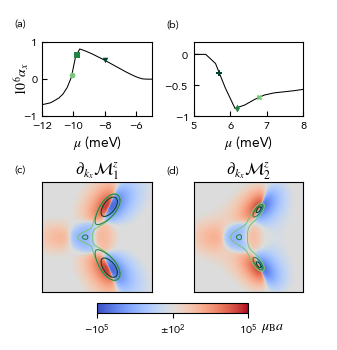

C:\Users\Brian\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.


Text(-0.25, 1.15, '(d)')

In [81]:
fig = plt.figure(figsize=(1 * width_in, 3.5))

gs = fig.add_gridspec(3, 3, width_ratios=[1, .1, 1], height_ratios=[.5, .1,1])
ax0a = fig.add_subplot(gs[0, 0])
ax0b = fig.add_subplot(gs[0, 2])
ax1 = fig.add_subplot(gs[2, 0], aspect='equal')
ax2 = fig.add_subplot(gs[2, 2], aspect='equal')
# ax0 = fig.add_subplot(211)
# ax1 = fig.add_subplot(223, aspect='equal')
# ax2 = fig.add_subplot(224, aspect='equal')

ax0a.plot(EFs, alphas[idx,:,0]*1e6, 'k')#'#55A868')
ax0a.set_xlim(-12, -5)
ax0a.set_ylim(-1, 1)
ax0a.set_xticks([-12, -10, -8, -6])

ax0b.plot(EFs, alphas[idx,:,0]*1e6, 'k')#'#55A868')
ax0b.set_xlim(5, 8)
ax0b.set_ylim(-1, .2)
ax0b.set_xticks([5, 6, 7, 8])
ax0b.set_yticks([-1, -0.5, 0])
ax0b.set_yticklabels([r'$\mathregular{-1}$', r'$\mathregular{-0.5}$', r'$\mathregular{0}$'])

ax0a.set_xlabel('$\mu$ (meV)', labelpad=2)
ax0a.set_ylabel(r'$10^6\alpha_x$', labelpad=-5)
ax0b.set_xlabel('$\mu$ (meV)', labelpad=2)
# ax0b.set_ylabel(r'$10^6\alpha_x$', labelpad=-5)

norm_dM=mpl.colors.SymLogNorm(linthresh=1e2, linscale=0,  vmin=-1e5, vmax=1e5)
im1 = ax1.pcolormesh(bs.Kxa, bs.Kya, dM1, **pcolormesh_params, cmap=cmapM, norm=norm_dM)
im2 = ax2.pcolormesh(bs.Kxa, bs.Kya, dM2, **pcolormesh_params, cmap=cmapM, norm=norm_dM)


    
# Zoom in by a factor
factor = 2
for a in [ax1, ax2]:
    x0, x1 = a.get_xlim()
    y0, y1 = a.get_ylim()
    a.set_xlim((x0 + x1) / 2 - (x1 - x0) / factor / 2, (x0 + x1) / 2 + (x1 - x0) / factor / 2)
    a.set_ylim((y0 + y1) / 2 - (y1 - y0) / factor / 2, (y0 + y1) / 2 + (y1 - y0) / factor / 2)
    a.set_xticks([])
    a.set_yticks([])

# # Make ax0 the same size as ax1, ax2
# x1, y1, w1, h1 = ax1.get_position().bounds
# x2, y2, w2, h2 = ax2.get_position().bounds
# x0, y0, w0, h0 = ax0.get_position().bounds
# bbox = mpl.transforms.Bbox.from_bounds(x1, y0 , x2 + w2-x1, h0)
# ax0.set_position(bbox)

## colorbar dM
ax1.set_title(r'$\partial_{k_x}\mathcal{M}^z_1$', pad=0)
ax2.set_title(r'$\partial_{k_x}\mathcal{M}^z_2$', pad=0)

l1, b1, w1, h1 = ax1.get_position().bounds
l2, b2, w2, h2 = ax2.get_position().bounds
cax = fig.add_axes([l1+w1/2, b1-.06, l2+w2/2-l1-w1/2, .03])
cbar = plt.colorbar(im2, cax=cax, orientation='horizontal')
cax.tick_params(direction='out', which='both')
cbar.set_ticks([-1e5, 0, 1e5])
labels = cax.get_xticklabels()
labels[1] = '$\\mathdefault{\pm10^2}$'
cax.text(1.08, -1.6, r'$\mu_{\mathrm{B}}a}$', transform=cax.transAxes)
# cax.text(1.11, -3.6, r'$\mu_{\mathrm{B}}a}$')
cax.set_xticklabels(labels)
values = np.arange(2,10)**3
minorticks = norm_dM(1e2 * np.concatenate((-values[::-1], values))) # Log-spaced ticks from 10^2 to 10^5
cax.xaxis.set_ticks(minorticks, minor=True);
    
markers = ['o', 's', 'v', 'P', 'd', 'X']
colors = np.vstack((mpl.cm.YlGn(np.linspace(0.5,1,3)), mpl.cm.YlGn(np.linspace(1,0.5,3))))
for j, (fb, marker, c) in enumerate(zip(fbs, markers, colors)):
    if j < 3:
        a = ax0a
    else:
        a = ax0b
    a.scatter(fb.EF * 1e3, griddata(EFs, alphas[idx,:,0], fb.EF*1e3) * 1e6, marker=marker, s=16, zorder=10, lw=0, color=c)
    for contour in fb.contours[1] + fb.contours[2]:
        if fb.EF < 0:
            ax1.plot(contour[:,0], contour[:,1], color=c, solid_capstyle='round')
        if fb.EF > 0:
            ax2.plot(contour[:,0], contour[:,1], color=c, solid_capstyle='round')
            
# Panel labels
ax0a.text(-.25, 1.3, '(a)', color='k', size=8, va='top', transform=ax0a.transAxes)
ax0b.text(-.25, 1.3, '(b)', color='k', size=8, va='top', transform=ax0b.transAxes)
ax1.text(-.25, 1.15, '(c)', color='k', size=8, va='top', transform=ax1.transAxes)
ax2.text(-.25, 1.15, '(d)', color='k', size=8, va='top', transform=ax2.transAxes)

In [82]:
savefig(fig, 'FigureTopo.pdf', 1, shift_x=0)

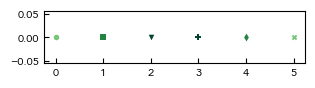

In [33]:
# another figure for the markers
fig, ax = plt.subplots(figsize=(width_in,.2*width_in))
for i, (marker, c) in enumerate(zip(markers, colors)):
    ax.scatter(i, 0, marker=marker, s=16, color=c, lw=0)
savefig(fig, 'FigureTopo_markers.pdf', 1)

## FigureAngle - angular dependence of the strain, current

In [92]:
g = glob.glob('data\summary*')

alphas = np.empty((len(g), 2))
alphadotEs1 = np.empty(len(g))
alphadotEs_perp1 = np.empty(len(g))
thetas = np.empty((len(g), 2))
thetas = np.arange(0, 24)*np.pi/24
print(len(g), len(thetas))
Delta = 4  # meV
EF = 4  # meV

for i, filename in enumerate(g):
    theta = float(filename[-8:-3])
#     thetas[i] = theta
    s = Saver.load(filename)
    j = np.where(s.Deltas == Delta)[0]  # index for specified Delta
    k = np.where(s.EFs == EF)[0]  # index for specified EF
#     print(s.Deltas[j], s.EFs[k])
    alphas[i] = s.alphas[j, k]
    
    # Current parallel with strain
    phi = theta
    alphadotEs1[i] = alphas[i].dot([np.cos(phi), np.sin(phi)])
    
    # Current perpendicular to strain
    phi = theta + np.pi/2
    alphadotEs_perp1[i] = alphas[i].dot([np.cos(phi), np.sin(phi)])

24 24


In [93]:
# repeat first period
thetas = np.linspace(0, 2*np.pi, 16*3+1)
alphadotEs = np.empty(16*3+1)
alphadotEs_perp = np.empty(16*3+1)

for j in range(3):
    for i in range(16):
        alphadotEs[16*j + i] = alphadotEs1[i]
        alphadotEs_perp[16*j + i] = alphadotEs_perp1[i]
alphadotEs[-1] = alphadotEs[0]
alphadotEs_perp[-1] = alphadotEs_perp[0]

<IPython.core.display.Javascript object>


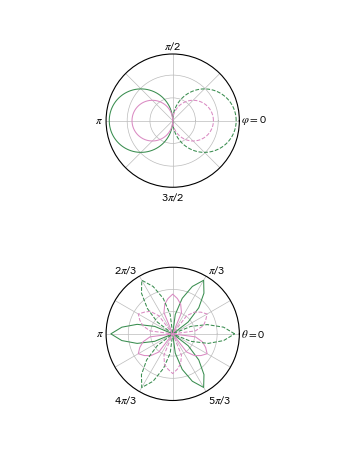

In [115]:
fig= plt.figure(figsize=(width_in, 4.5))
ax2 = fig.add_subplot(211, projection='polar') # swapped these - ax2 is on top now
ax = fig.add_subplot(212, projection='polar')

ax.grid(linewidth=0.5, color='#BBBBBB')
ax2.grid(linewidth=0.5, color='#BBBBBB')

# Rotating strain

# c1 = '#55A868'
c1 = '#398D4F'
c2 = '#DA8BC3'
ax.plot(thetas, alphadotEs * (alphadotEs > 0), label=r' ', color=c1)
ax.plot(thetas, alphadotEs_perp * (alphadotEs_perp > 0), label=r' ', color=c2)
ax.plot(thetas, -alphadotEs * (alphadotEs < 0), ls='--', color=c1)
ax.plot(thetas, -alphadotEs_perp * (alphadotEs_perp < 0), ls='--', color=c2)
ax.set_ylim(0, 1.5e-6)
ax.set_yticklabels([])
ax.tick_params(pad=2)


xticks = np.arange(0,12) * np.pi / 6
xticklabels = [r'     $\theta=$0', '', '$\pi$/3', '', '2$\pi$/3', '', '$\pi$', '', '4$\pi$/3', '', '5$\pi$/3', '']
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, va='center')    
# ax.legend(bbox_to_anchor=(1.15, 1), loc='upper left', borderaxespad=0, handlelength=1, labelspacing=4.5, borderpad=1.5)

# tweak alignment of tick labels
offset_coords = [[-0.06, 0], [0, 0], [0.04,-0.05], [0,0], [-0.07,-0.05], [0,0], [0.06,0], [0,0], [-0.07,0.02], [0,0], [0.07,0.02], [0,0]]
for label, coords in zip(ax.xaxis.get_majorticklabels(), offset_coords):
    offset = mpl.transforms.ScaledTranslation(*coords, fig.dpi_scale_trans)
    label.set_transform(label.get_transform() + offset)


# Rotating E

phis = np.linspace(0, 2*np.pi, 500)
alphadotEs_zz = alphas[0].dot([np.cos(phis), np.sin(phis)])
ax2.plot(phis, alphadotEs_zz * (alphadotEs_zz > 0), color=c1, label=' ')
ax2.plot(phis, -alphadotEs_zz * (alphadotEs_zz < 0), color=c1, ls='--')
alphadotEs_ac = alphas[12].dot([np.cos(phis), np.sin(phis)])
ax2.plot(phis, alphadotEs_ac * (alphadotEs_ac > 0), color=c2, label=' ')
ax2.plot(phis, -alphadotEs_ac * (alphadotEs_ac < 0), color=c2, ls='--')

ax2.set_yticklabels([])

xticks = np.arange(0,8) * np.pi / 4
xticklabels = [r'     $\varphi=$0', '', '$\pi$/2', '', '$\pi$', '', '3$\pi$/2', '']
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticklabels, va='center')

# tweak alignment of tick labels
offset_coords = [[-0.07, 0], [0,0], [0,-0.07], [0,0], [0.07,0], [0,0], [0,0.05], [0,0]]
for label, coords in zip(ax2.xaxis.get_majorticklabels(), offset_coords):
    offset = mpl.transforms.ScaledTranslation(*coords, fig.dpi_scale_trans)
    label.set_transform(label.get_transform() + offset)


# ax2.legend(bbox_to_anchor=(1.15, 1), loc='upper left', borderaxespad=0, handlelength=1, labelspacing=4.5, borderpad=1.5)

plt.subplots_adjust(hspace=0.6)

# ax2 = fig.add_axes((.1,.53,.0,.35))
# ax2.xaxis.set_visible(False) # hide x axis
# ax2.set_yticks(np.linspace(0,1,7)) # set new tick positions
# ax2.set_yticklabels(['-1.5', '-1', '-0.5', '0', '0.5', '1', '1.5'])
# ax2.yaxis.set_minor_locator(AutoMinorLocator(2)) # set minor tick for every second tick

# ax.annotate('', xy=(0, 1), xycoords='axes fraction', xytext=(1, 0), transform=ax.transAxes,
#             arrowprops=dict(arrowstyle="<->", color='b'))

# Panel labels
# ax.text(-.1, 1.2, '(a)', color='k', size=8, va='top', transform=ax.transAxes)
# ax2.text(-.1, 1.2, '(b)', color='k', size=8, va='top', transform=ax2.transAxes)

In [116]:
savefig(fig, 'FigureAngle.pdf', 1, shift_x=.8)

# FigureStrain - strain dependence

In [254]:
sZZ = Saver.load(r'.\data\strainseries_ZZ.h5')
sAC = Saver.load(r'.\data\strainseries_AC.h5')

In [264]:
# c1 = 'k'
# c2 = 'C2'
# c1 = '#8C8C8C'
c1 = 'k'
c2 = '#398D4F'
c3 = 'C3'
c4 = 'C7'
c0 = 'C0'
ls3 = '--'
ls4 = '-.'
ls0 = ':'

<IPython.core.display.Javascript object>


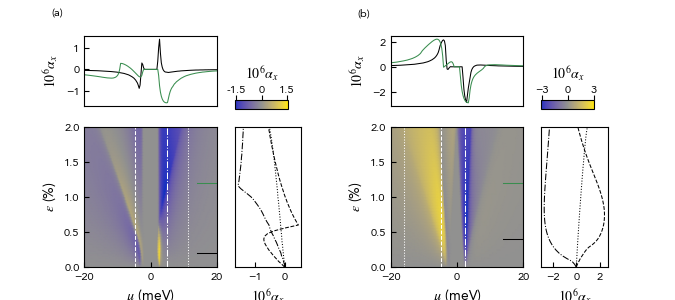

Text(-0.25, 1.4, '(b)')

In [276]:
fig= plt.figure(figsize=(width_in*2, 3))
gs = fig.add_gridspec(2, 5, width_ratios=[1, .5, .4, 1, .5], height_ratios=[.5, 1])
axZZ = fig.add_subplot(gs[1, 0])  # 2D color plot (EF, strain, alpha)
axZZ_x = fig.add_subplot(gs[0, 0])  # alpha vs EF linecut
axZZ_y = fig.add_subplot(gs[1, 1])  # alpha vs strain linecut
axAC = fig.add_subplot(gs[1, 3])
axAC_x = fig.add_subplot(gs[0, 3])
axAC_y = fig.add_subplot(gs[1, 4])

# Hide redundant axis labels
axZZ_x.set_xticks([])
axAC_x.set_xticks([])
axZZ_y.set_yticks([])
axAC_y.set_yticks([])

# Plot for one choice of Delta
v = abs(sZZ.alphas1).max()*1e6
imZZ = axZZ.pcolormesh(sZZ.EFs, sZZ.strains*100, sZZ.alphas1*1e6, **pcolormesh_params, cmap=cmapA, vmin=-v, vmax=v)
for i, c in zip([5, 30], [c1, c2]):
    axZZ_x.plot(sZZ.EFs, sZZ.alphas1[i, :]*1e6, label=sZZ.strains[i], color=c)
    axZZ.axhline(sZZ.strains[i]*100, 0.85, 1, color=c)
for j, c, ls in zip([57, 93], [c3, c4], [ls3, ls4]):
# for j, c in zip([55, -1], ['C3', 'C7']):
    axZZ_y.plot(sZZ.alphas1[:, j]*1e6, sZZ.strains*100, label=sZZ.EFs[i], color='k', ls=ls)
    axZZ.axvline(sZZ.EFs[j], color='w', ls=ls)
# Linear
j = -34
axZZ_y.plot(sZZ.alphas1[:, j]*1e6, sZZ.strains*100, label=sZZ.EFs[i], color='k', ls=ls0)
axZZ.axvline(sZZ.EFs[j], color='w', ls=ls0)
# axZZ_y.text(-.1, .25, '×5', color=c0)

v = abs(sAC.alphas1).max()*1e6
imAC = axAC.pcolormesh(sAC.EFs, sAC.strains*100, sAC.alphas1*1e6, **pcolormesh_params, cmap=cmapA, vmin=-v, vmax=v)
for i, c in zip([10, 30], [c1, c2]):
    axAC_x.plot(sAC.EFs, sAC.alphas1[i, :]*1e6, label=sAC.strains[i], color=c)
    axAC.axhline(sAC.strains[i]*100, 0.85, 1, color=c)
for j, c, ls in zip([57, 84], [c3, c4], [ls3, ls4]):
    axAC_y.plot(sAC.alphas1[:, j]*1e6, sAC.strains*100, label=sAC.EFs[i], color='k', ls=ls)
    axAC.axvline(sAC.EFs[j], color='w', ls=ls)
# Linear
j = 15
axAC_y.plot(sAC.alphas1[:, j]*1e6, sAC.strains*100, label=sAC.EFs[i], color='k', ls=ls0)
axAC.axvline(sAC.EFs[j], color='w', ls=ls0)
    
# Colorbars
l, b, w, h = axZZ_y.get_position().bounds
cax = fig.add_axes([l, b + h + .06, w*.8, .03])
cbar = plt.colorbar(imZZ, cax=cax, orientation='horizontal')
cax.tick_params(direction='out', which='both', pad=0)
cax.set_xlabel(r'$10^6\alpha_x$')
# cax.text(1.2, 0.5, r'$10^6\alpha_x$', transform=cax.transAxes, va='center')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')
cbar.set_ticks([-1.5, 0, 1.5])
cax.set_xticklabels([-1.5, 0, 1.5])

l, b, w, h = axAC_y.get_position().bounds
cax = fig.add_axes([l, b + h + .06, w*.8, .03])
cbar = plt.colorbar(imAC, cax=cax, orientation='horizontal')
cax.tick_params(direction='out', which='both', pad=0)
cax.set_xlabel(r'$10^6\alpha_x$')
# cax.text(1.2, 0.5, r'$10^6\alpha_x$', transform=cax.transAxes, va='center')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')
cbar.set_ticks([-3, 0, 3])

    
# Tweak axis limits and ticks
axZZ_x.set_xlim(-20, 20)
axAC_x.set_xlim(-20, 20)
axAC_x.set_yticks([-2, 0, 2])
axZZ_y.set_ylim(0, 2)
axAC_y.set_ylim(0, 2)
axAC_y.set_xticks([-2, 0, 2])

# Labels
axZZ.set_xlabel(r'$\mu$ (meV)')
axZZ.set_ylabel(r'$\varepsilon$ (%)')
axZZ_x.set_ylabel(r'$10^6\alpha_x$')
axZZ_y.set_xlabel(r'$10^6\alpha_x$')

axAC.set_xlabel(r'$\mu$ (meV)')
axAC.set_ylabel(r'$\varepsilon$ (%)')
axAC_x.set_ylabel(r'$10^6\alpha_x$')
axAC_y.set_xlabel(r'$10^6\alpha_x$')

# Panel labels
axZZ_x.text(-.25, 1.4, '(a)', color='k', size=8, va='top', transform=axZZ_x.transAxes)
axAC_x.text(-.25, 1.4, '(b)', color='k', size=8, va='top', transform=axAC_x.transAxes)

In [278]:
sZZ.strains[5], sZZ.strains[30], sZZ.EFs[57], sZZ.EFs[93], sZZ.EFs[-34]

(0.002, 0.012, -4.8, 4.8, 11.2)

In [279]:
sAC.strains[10], sAC.strains[30], sAC.EFs[57], sAC.EFs[84], sAC.EFs[15]

(0.004, 0.012, -4.8, 2.4, -16.0)

In [280]:
savefig(fig, 'FigureStrain.pdf', 2, shift_y=-0.1, tweak_height=1.1)

# FigureDetect - visualizing how we can detect using mag imaging

In [83]:
# 2 micron window
x = np.linspace(-1, 1, 500) * 1e-6
y = np.linspace(-1, 1, 500) * 1e-6
X, Y = np.meshgrid(x,y)

w, h = 1e-6, 1e-6  # 1um x 1um device
z = 0.1e-6  # 100 nm scan height

I = 10e-6  # ampere
M = 0.05 * I

Bslab = B_mag_rect(X, Y, z, w, h, M) * 1e9 # nT
Bwire = B_wire_width(X, Y, z, h, I, direction='+x') * 1e9 # nT

<IPython.core.display.Javascript object>


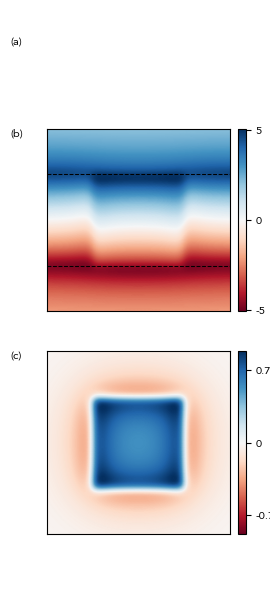

In [86]:
fig= plt.figure(figsize=(width_in*.8, 6))

gs = fig.add_gridspec(4, 1, height_ratios=[.2, 1, 0, 1])
ax0 = fig.add_subplot(gs[0,0], aspect='equal')
ax0.axis('off')
ax1 = fig.add_subplot(gs[1,0], aspect='equal')
ax1.set_xticks([])
ax1.set_yticks([])
ax2 = fig.add_subplot(gs[3,0], aspect='equal')
ax2.set_xticks([])
ax2.set_yticks([])


v = np.max(np.abs(Bslab + Bwire))
im1 = ax1.pcolormesh(X, Y, (Bslab + Bwire)*1e-3, cmap=cmapB, vmin=-v*1e-3, vmax=v*1e-3, **pcolormesh_params)

v = np.max(np.abs(Bslab))
im2 = ax2.pcolormesh(X, Y, Bslab*1e-3, cmap=cmapB, vmin=-v*1e-3, vmax=v*1e-3, **pcolormesh_params)

l, b, w, h = ax1.get_position().bounds
cax = fig.add_axes([l + w + .03, b, .03, h])
cbar = plt.colorbar(im1, cax=cax)
cax.tick_params(direction='out', which='both')
cax.set_ylabel('$B_z$ (μT)')
cbar.set_ticks([-5, 0, 5])
cax.set_yticklabels([-5, 0, 5])

l, b, w, h = ax2.get_position().bounds
cax = fig.add_axes([l + w + .03, b, .03, h])
cbar = plt.colorbar(im2, cax=cax)
cax.tick_params(direction='out', which='both')
cax.set_ylabel('$\Delta B_z$ (μT)')
cbar.set_ticks([-0.7, 0, 0.7])
cax.set_yticklabels([-0.7, 0, 0.7])

# Square outline
# p = Polygon(np.array([[1,1],[1,-1],[-1,-1],[-1,1]])*.5e-6, fill=None, color='k', ls='--')
# ax1.add_patch(p)
ax1.axhline(-.5e-6, color='k', ls='--')
ax1.axhline(.5e-6, color='k', ls='--')


# Panel labels
ax1.text(-0.2, 1.5, '(a)', color='k', size=8, va='top', transform=ax1.transAxes)
ax1.text(-0.2, 1, '(b)', color='k', size=8, va='top', transform=ax1.transAxes)
ax2.text(-0.2, 1, '(c)', color='k', size=8, va='top', transform=ax2.transAxes)

fig.subplots_adjust(wspace=0)

In [87]:
savefig(fig, 'FigureDetect.pdf', 1, shift_x=.3)

# Scratch

In [48]:
sl = StrainedLattice(0.2)
sl.calculate()

In [49]:
sl0 = StrainedLattice(0)
sl0.calculate()

<IPython.core.display.Javascript object>


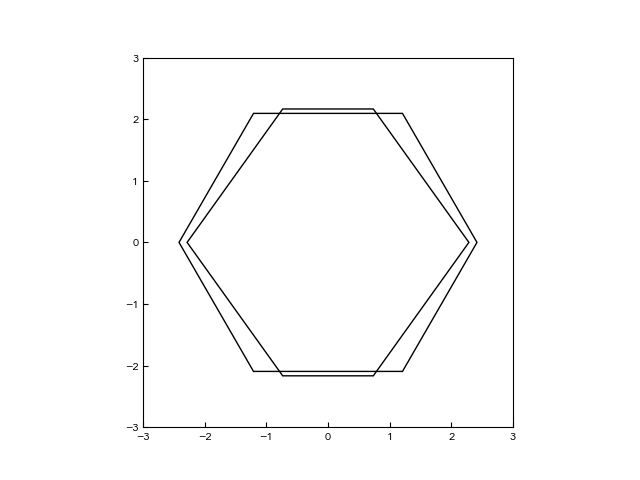

In [50]:
fig, ax = plt.subplots()
p = Polygon(sl.bz, fill=None)
ax.add_patch(p)
p = Polygon(sl0.bz, fill=None)
ax.add_patch(p)

ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.set_aspect(1)